<a href="https://colab.research.google.com/github/inteligenciafrvm/inteligenciafrvm/blob/master/Clases%20pr%C3%A1cticas/7.%20Intro%20a%20redes%20neuronales%20con%20Pytorch%20I.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introducción a las Redes Neuronales con Pytorch - Parte I

* Intro a Pytorch.
* Implementación de autograd y descenso de gradiente.
* Pytorch con redes neuronales.
* Ejemplo de entrenamiento y evaluación.


5to año - Ingeniería en Sistemas de Información

UTN - Facultad Regional Villa María

Parte de este notebook está basado en material del curso de Aprendizaje Automático y Visión por Computadoras dictado en FaMAF, UNC por Jorge A. Sánchez, y en tutoriales oficiales de pytorch.

## Introducción a Pytorch

Pytorch es un framework open source para Machine Learning. Al igual que numpy, maneja arrays multidimensionales (aquí llamados *tensores*) y tiene una interfaz parecida(\*). Se destaca en que brinda soporte para redes neuronales (con su módulo de autograd para el cómputo automático de los gradientes) y sus librerías están optimizadas para operar con tensores en GPUs. Junto con [Tensorflow](https://www.tensorflow.org/) son los dos frameworks principales de NNs del momento (otro framework que asoma: [JAX](https://github.com/google/jax)).

Se recomienda leer los siguientes tutoriales para obtener una idea rápida (parte de este notebook está basado en ellos):

1. [What is pytorch?](https://pytorch.org/tutorials/beginner/blitz/tensor_tutorial.html#sphx-glr-beginner-blitz-tensor-tutorial-py)

1. [Autograd: automatic differentiation](https://pytorch.org/tutorials/beginner/blitz/autograd_tutorial.html#sphx-glr-beginner-blitz-autograd-tutorial-py)

Otros links de referencia:

1. [torch package](https://pytorch.org/docs/stable/torch.html)

1. [torch.nn](https://pytorch.org/docs/stable/nn.html)

1. [torch.tensor](https://pytorch.org/docs/stable/tensors.html)

(\*) nota: varias de las operaciones con ndarrays de numpy no están disponibles en pytorch o requieren procesamiento adicional, por tanto arrojarán errores. Ejemplo común: muchas funciones en pytorch requieren se designe específicamente el tipo de datos de salida, como

    dtype=torch.float32

y que el mismo coincida con el tipo de datos que se venía procesando

De no hacerlo arroja error de tipo.

Para instalar Pytorch lo más recomendable es ir a la página oficial https://pytorch.org/ y seleccionar la opción según su sitema operativo y hardware. **Importante!** sólo seleccionar Cuda si se cuenta con placa de video Nvidia con dicha versión de Cuda, de lo contrario varias porciones de código (sobretodo del siguiente notebook) no van a compilar. Si no se cuenta con placa de video, seleccionar None para poder correr los modelos desde el CPU.

In [1]:
import numpy as np
import torch
from torch import nn

import matplotlib
%matplotlib inline

import matplotlib.pyplot as plt

import warnings
warnings.simplefilter('ignore')

np.random.seed(12345)

Algunos ejemplos y diferencias con numpy útiles de recordar:

In [2]:
# torch.tensor() sería el np.array en numpy
x = torch.tensor([1,2,3,4])
print(x)

tensor([1, 2, 3, 4])


In [3]:
# creamos un tensor de dimensiones 4x2 "vacío"
x = torch.empty(4, 2)
print(x)

tensor([[5.2158e-11, 6.8571e+22],
        [1.8060e+28, 3.0301e+35],
        [1.8936e+23, 7.2076e+31],
        [2.7490e+20, 1.8470e+31]])


In [4]:
# tenemos disponibles las  manipulaciones usuales con vectores
print(x + 1e-20)

tensor([[5.2158e-11, 6.8571e+22],
        [1.8060e+28, 3.0301e+35],
        [1.8936e+23, 7.2076e+31],
        [2.7490e+20, 1.8470e+31]])


In [5]:
# x.view sería en numpy el np.resize()
# cambiamos nuestro tensor de 4x2 a 8x1
x_2 = x.view((-1,1))  # -1 significa "inferir dimensión" (cuando sea posible)
print(x_2)

tensor([[5.2158e-11],
        [6.8571e+22],
        [1.8060e+28],
        [3.0301e+35],
        [1.8936e+23],
        [7.2076e+31],
        [2.7490e+20],
        [1.8470e+31]])


In [6]:
# torch.size sería np.shape()
print(x.size())

torch.Size([4, 2])


### Conexión con numpy

Es posible traer tensores de numpy a ndarray y viceversa. Para ello puede usarse lo siguiente:

In [7]:
a = torch.tensor([1,2,3])
b = a.numpy()
print(a, b)

tensor([1, 2, 3]) [1 2 3]


Atención: los mismos comparten memoria, entonces

In [8]:
a +=1
b +=1
print(a,b)

tensor([3, 4, 5]) [3 4 5]


Para evitar que compartan memoria, tenemos que clonar el objeto, por ejemplo

In [9]:
c = a.clone() + 1
d = np.copy(b) + 1
print(a, b, c, d)

tensor([3, 4, 5]) [3 4 5] tensor([4, 5, 6]) [4 5 6]


### Tensores en GPU

Del tutorial de pytorch: así es como se crea un objeto en la memoria de la GPU

In [10]:
# let us run this cell only if CUDA is available
# We will use ``torch.device`` objects to move tensors in and out of GPU
if torch.cuda.is_available():
    device = torch.device("cuda")          # a CUDA device object
    y = torch.ones_like(x, device=device)  # directly create a tensor on GPU
    x = x.to(device)                       # or just use strings ``.to("cuda")``
    z = x + y
    print(z)
    print(z.to("cpu", torch.double))       # ``.to`` can also change dtype together!

Nota: para correr esto necesitan tener en su PC una GPU con CUDA (Nvidia) o bien pueden usar una GPU compartida desde un notebook de Google Colab yendo a *Edit -> Notebook settings ->* y cambiando Hardware accelerator de *None* a *GPU*.

### Autograd

Una de las características principales de Pytorch es el paquete Autograd. El mismo computa y acumula automáticamente los gradientes a medida que se realizan las distintas operaciones en la red neuronal.

Función de ejemplo: $(x_1^3 - 15)^2 + e^{2x_2}$

Derivada: $2(x_1^3 - 15)(3x_1^2) + 2e^{2x_2}$

Punto inicial de evaluación: $X_t = (3,5)$

Bonus: hay una librería de python que permite hacer estas operaciones aritméticas simbólicas: [sympy](https://www.sympy.org/en/index.html)

In [11]:
import sympy as sp
x_1,x_2 = sp.symbols('x_1,x_2')
f_sp = (x_1**3 - 15)**2 + sp.exp(2*x_2)
print('d/dx1 = {}'.format(sp.diff(f_sp, x_1)))
print('d/dx2 = {}'.format(sp.diff(f_sp, x_2)))

d/dx1 = 6*x_1**2*(x_1**3 - 15)
d/dx2 = 2*exp(2*x_2)


Iniciamos nuestro tensor

In [12]:
# requires_grad es lo que hará que se computen los gradientes
# con dtype pasamos explícitamente el tipo de datos
x = torch.tensor([3,5], requires_grad=True, dtype=torch.float32)  
print(x)

tensor([3., 5.], requires_grad=True)


A modo didáctico, hacemos primero el paso por paso para que se vea cómo se acumulan los gradientes

In [13]:
z11 = (x[0]**3 - 15)  # gradiente: 3*x1**2 |3 = 27
z12 = z11**2  # gradiente: 2(x1**3 - 15)*27 |3 = 648
# notar que tienen que usarse torch.log porque no puede 
# pasarse un tensor que requiere gradiente en numpy
z2 = torch.exp(2*x[1]) # gradiente: 2e**(2x2) |5 = 44052. 
y = z12 + z2  # Gradiente acumulado: 648 + 44052
print('Resultado: {}'.format(y))
y.backward() # el método backward() calcula los gradientes de las operaciones que hicimos.
print('Gradiente: {}'.format(x.grad))

Resultado: 22170.46484375
Gradiente: tensor([  648.0000, 44052.9297])


Iniciamos nuevamente nuestro tensor y hacemos esto mismo en una sola operación

In [14]:
x = torch.tensor([3,5], requires_grad=True, dtype=torch.float32)  
y = (x[0]**3 - 15)**2 + torch.exp(2*x[1])
y.backward()  
print('Gradiente: {}'.format(x.grad))

Gradiente: tensor([  648.0000, 44052.9297])


Comparamos los resultados con la función derivada manualmente

In [15]:
# detach nos da el valor sin computar gradientes
y_dx1, y_dx2 = (6*x[0]**2*(x[0]**3 - 15)).detach(), (2*torch.exp(2*x[1])).detach()  
print(y_dx1, y_dx2)

tensor(648.) tensor(44052.9297)


Si nuestra función objetivo $f$ es una función que quisieramos minimizar (por ejemplo en una función de error) siendo $x$ su parámetro, el algoritmo de desdenso de gradiente propone tomar pasos hacia la dirección de ese gradiente, debido a que es donde más rápido decrece la función, de forma que

$$X_{t+1} = X_{t} - \alpha \nabla f(X_t)$$

donde $\alpha$ es un número pequeño como $\alpha=2x10^{-4}$

Para nuestro ejemplo $X$ actualizado quedaría: $X_{t+1} = (2.9, -3.81)$, pudiendo observar que dicho valor efectivamente hace decrecer la función en dirección a los elementos de $X$ que más aportan al error.

Este que vimos fue un ejemplo de juguete, pero la potencia real está en poder realizar esto en una red neuronal potente, en donde usaremos este mismo algoritmo para actualizar los pesos $w$.

Por ejemplo, generalizando para una red neuronal dada por la siguiente imagen, podemos ver cómo sería el cálculo de la derivada de la función de costo con respecto a $x_1$

![](images/7/chain_rule_derivatives.png)

## Pytorch y redes neuronales

Repaso rápido:

* Epoch: en una época, todo el dataset de entrenamiento es pasado (tomado como entrada, determinada la salida y calculados los gradientes) por la red neuronal (NN) 

* Para optimizar el modelo, los gradientes pueden actualizarlo de varias formas, para ello un híper-parámetro útil es el número de datos de entrenamiento que usaremos para estimar el gradiente, denominado *batch-size*. Dados $n$ ejemplos del conjunto de entrenamiento. Vemos algunos algoritmos básicos:

    * Batch gradient descent (batch-size = $n$): se hace una pasada completa del conjunto de entrenamiento, estimando el gradiente a partir de la función de costo de todas las muestras del mismo y se actualiza el modelo al final del epoch. Es la forma más eficiente computacionalmente, converge en funciones convexas pero actualizar de esta manera el modelo la convergencia puede resultar muy lenta.
    
    * Stochastic gradient descent (SGD, batch-size = $1$): se pasa muestra por muestra del conjunto de entrenamiento (ordenado aleatoriamente), y por cada una de esas muestras se calcula el error de la función de costo y se computa el gradiente, actualizando el modelo tras cada una. Hacer esto es la forma más demandante computacionalmente.
    
    * Mini-batch gradient descent (batch-size < $n$): se divide el conjunto de entrenamiento en partes (*minibatches*). Se realiza una pasada por cada minibatch, calculando el error para todas muestras del minibatch y actualizando el modelo con dicho error. Presenta un equilibrio entre SGD y Batch, balanceando convergencia con demanda computacional.
 
  No obstante, en la práctica suelen usarse formas más refinadas de los algoritmos que vimos aquí. Este post muestra una excelente vista general de ellas https://ruder.io/optimizing-gradient-descent/.
 
* Regularización: al optimizar el modelo, para evitar que los pesos de la red tomen valores demasiado altos y generen overfitting, consiste en añadirle a la función de costo un término de regularización, que asigne mayor costo mientras más grande sean esos pesos. Una común es la regularización $L2 = ||w||^2_2 = \lambda \sum w_{ij}^2$, donde $\lambda$ es un híper-parámetro llamado *weight decay*, que toma valores pequeños como $\lambda = 1 \times 10^{-3}$.

### Ejemplo 1. Regresión polinomial

Primero, generamos un dataset "de juguete" con la función provista en el módulo utils

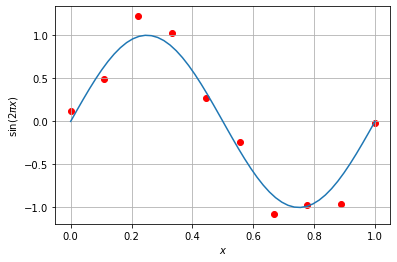

In [16]:
from utils import create_sinusoidal_data as create_data

x_train, y_train, x_test, y_test = create_data()

plt.plot(x_test, y_test)
plt.scatter(x_train, y_train, color='red')
plt.ylabel('$\sin(2 \pi x)$')
plt.xlabel('$x$')
plt.grid()

Usaremos dos redes neuronales. Para la primera trabajaremos con el siguiente modelo polinomial de orden $P$, para cada entrada $i$:
$$
y(x; \mathbf{w}) = \sum_{p=0}^P w_p x^p,
$$
el cual podemos expresar como un modelo linear en $\mathbb{R}^{P+1}$ como:

$$
y(x; \mathbf{w}) = \mathbf{w}^T \mathbf{x} + w_0,
$$

donde $$\mathbf{w}={(w_1, \dots, w_P)}^T$$ $$\mathbf{x}={(x, x^2, \dots, x^P)}^T$$ y $w_0$ es el sesgo (bias)

La función ``polynomial_features`` provee dicha funcionalidad.

In [17]:
from utils import polynomial_features

P = 3

x_train_vec = polynomial_features(x_train, P)
y_train_vec = y_train.reshape(-1, 1) # aumentamos nuestro tensor de 1D a 2D pues así lo usará nuestro modelo

x_test_vec = polynomial_features(x_test, P)
y_test_vec = y_test.reshape(-1, 1)

print(x_train_vec.shape, x_test_vec.shape)

(10, 3) (50, 3)


In [18]:
print(x_train)

[0.         0.77777778 0.33333333 1.         0.66666667 0.44444444
 0.11111111 0.88888889 0.55555556 0.22222222]


In [19]:
print(x_train_vec)

[[0.         0.         0.        ]
 [0.77777778 0.60493827 0.47050754]
 [0.33333333 0.11111111 0.03703704]
 [1.         1.         1.        ]
 [0.66666667 0.44444444 0.2962963 ]
 [0.44444444 0.19753086 0.0877915 ]
 [0.11111111 0.01234568 0.00137174]
 [0.88888889 0.79012346 0.70233196]
 [0.55555556 0.30864198 0.17146776]
 [0.22222222 0.04938272 0.01097394]]


Cada $x_i \in X_{train}$ procesado con polynomial features sirve como entrada de las siguientes redes neuronales. Las mismas procesan cada una de las entradas $i$ con la primera arquitectura (la segunda es la que hay que implementar en el TP2).

![Red neuronal de ejemplo](images/7/red_nn_ejemplo.png)

### Definición del modelo

Comenzaremos con la definición del modelo de regresión heredando de ``nn.Module`` como sigue. 

In [20]:

class LinearRegression(nn.Module):
    def __init__(self, num_features):
        super().__init__()        
        self.fc = nn.Linear(in_features=num_features, out_features=1, bias=True)
        
    def forward(self, x):
        out = self.fc(x)
        return out
    

class FeedforwardNet(nn.Module):
    def __init__(self, num_features, num_hidden):
        super().__init__()        
        # completa con tu código aquí
        
    def forward(self, x):
        # completa con tu código aquí
        return 0.

Instanciamos nuestro modelo

In [21]:
model = LinearRegression(num_features=P)

# si tenemos GPU, llevamos el modelo ahí
if torch.cuda.is_available():
    device = torch.device('cuda:0')
else:
    device = torch.device('cpu')    

model.to(device)

LinearRegression(
  (fc): Linear(in_features=3, out_features=1, bias=True)
)

Probamos nuestro modelo en modo evaluación

In [22]:
# model.eval() pone el modelo en "evaluación", desactivando particularidades de entrenamiento
# estas se reactivan cuando hacemos model.train()
model.eval()

# aquí impedimos se procesen gradientes ya que estamos evaluando
with torch.no_grad():
    inputs_all = torch.from_numpy(np.float32(x_train_vec))
    
    input_single = inputs_all[1]
    output_single = model(torch.from_numpy(np.float32(inputs_all[1])))
    output_all = model(torch.from_numpy(np.float32(inputs_all)))
    print('Ejemplo de 1 vector de entrada: {}'.format(input_single))
    print('Salida para ese vector: {}'.format(output_single))
    print('Salida para cada entrada:\n {}'.format(output_all))

Ejemplo de 1 vector de entrada: tensor([0.7778, 0.6049, 0.4705])
Salida para ese vector: tensor([0.2028])
Salida para cada entrada:
 tensor([[0.3206],
        [0.2028],
        [0.2326],
        [0.1916],
        [0.2065],
        [0.2195],
        [0.2812],
        [0.1985],
        [0.2114],
        [0.2525]])


### Función de costo y algoritmo de optimización

Utilizaremos la función de costo error cuadrático medio (MSE) y optimizamos el modelo con descenso de gradiente estocástico (SGD).

In [23]:
from torch.optim import SGD

model.train()  # modelo nuevamente activado para entrenamiento

LEARNING_RATE = 0.1
WEIGHT_DECAY = 0.0  # L2 regularization coef.

criterion = nn.MSELoss(reduction='sum')

optimizer = SGD(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

### Entrenamiento

In [24]:
EPOCHS = 10000

x_train_tensor = torch.from_numpy(np.float32(x_train_vec))
y_train_tensor = torch.from_numpy(np.float32(y_train_vec))
n_train = len(x_train_tensor)

x_test_tensor = torch.from_numpy(np.float32(x_test_vec))
y_test_tensor = torch.from_numpy(np.float32(y_test_vec))
n_test = len(x_test_tensor)

train_loss = []
test_loss = []

for epoch in range(EPOCHS):
        
    optimizer.zero_grad()                                # limpia todos los gradientes
    y_pred = model(x_train_tensor)                       # realiza predicción con el modelo (forward pass)
    loss = criterion(y_pred, y_train_tensor) / n_train   # calcula la pérdida (loss) y la divide por # obs
    loss.backward()                                      # calcula los gradientes (backward pass)
    optimizer.step()                                     # realiza paso de optimización, actualizando pesos
    
    train_loss.append(loss.detach().item())
    
    with torch.no_grad():
        y_pred = model(x_test_tensor)
        loss = criterion(y_pred, y_test_tensor) / n_test
        test_loss.append(loss.item())
                
    if epoch % (EPOCHS//10) == 0:
        print("epoch = {:02d}, train_loss = {:.3e}, test_loss = {:.3e}".format(epoch, train_loss[-1], test_loss[-1]))

epoch = 00, train_loss = 6.274e-01, test_loss = 4.395e-01
epoch = 1000, train_loss = 3.164e-01, test_loss = 1.984e-01
epoch = 2000, train_loss = 2.981e-01, test_loss = 1.848e-01
epoch = 3000, train_loss = 2.815e-01, test_loss = 1.732e-01
epoch = 4000, train_loss = 2.660e-01, test_loss = 1.624e-01
epoch = 5000, train_loss = 2.514e-01, test_loss = 1.523e-01
epoch = 6000, train_loss = 2.377e-01, test_loss = 1.428e-01
epoch = 7000, train_loss = 2.249e-01, test_loss = 1.340e-01
epoch = 8000, train_loss = 2.128e-01, test_loss = 1.258e-01
epoch = 9000, train_loss = 2.015e-01, test_loss = 1.181e-01


### Visualización

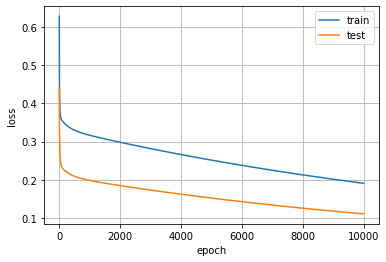

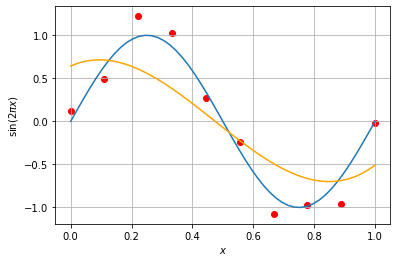

In [25]:
plt.figure()
plt.plot(np.arange(EPOCHS), train_loss)
plt.plot(np.arange(EPOCHS), test_loss)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'])
plt.grid()

model.eval()  
y_pred = model(x_test_tensor)
y_pred = y_pred.detach().numpy().squeeze()

plt.figure()
plt.plot(x_test, y_test)
plt.plot(x_test, y_pred, color='orange')
plt.scatter(x_train, y_train, color='red')
plt.ylabel('$\sin(2 \pi x)$')
plt.xlabel('$x$')
plt.grid()

### Usando data loaders y mini-batch SGD

Volvemos a instanciar el modelo, criterio y optimizador:

In [26]:
model = LinearRegression(num_features=P)

if torch.cuda.is_available():
    device = torch.device('cuda:0')
else:
    device = torch.device('cpu')    

model.to(device)

criterion = nn.MSELoss(reduction='sum')

optimizer = SGD(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

Pytorch provee distintas clases para el accesso a datos, como los *TensorDataset* y *DataLoader*.

* *DataLoader* nos permite realizar iteraciones sobre un dataset. Es especialmente útil para iterar sobre datasets grandes, como por ejemplo los datasets de imágenes, permitiendo abstraernos de tener que implementar código específico para manejar aspectos como las rutas de los archivos o la aleatoriedad en su iteración.

* *TensorDataset*, por otra parte, nos permite generar un dataset de tensores para ser iterado a partir del DataLoader.


In [27]:
from torch.utils import data

BATCH_SIZE = 5

train_data = data.TensorDataset(x_train_tensor, y_train_tensor)
train_loader = data.DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True, num_workers=0,)

test_data = data.TensorDataset(x_test_tensor, y_test_tensor)
test_loader = data.DataLoader(dataset=test_data, batch_size=BATCH_SIZE, shuffle=False, num_workers=0,)

print(len(train_data), len(train_loader))

10 2


In [28]:
train_loss, test_loss = [], []

for epoch in range(EPOCHS):
       
    train_loss_acc = 0.    
    for x, y in train_loader:
        x.to(device, non_blocking=True)
        y.to(device, non_blocking=True)
                
        optimizer.zero_grad()
        y_pred = model(x)
        loss = criterion(y_pred, y) / BATCH_SIZE
        loss.backward()
        optimizer.step()
        
        train_loss_acc += loss.detach().item()
    train_loss.append(train_loss_acc / len(train_data))        
    
    with torch.no_grad():
        test_loss_acc = 0.
        for x, y in test_loader:        
            x.to(device, non_blocking=True)
            y.to(device, non_blocking=True)        
            
            y_pred = model(x)      
            loss = criterion(y_pred, y)
            
            test_loss_acc += loss.item()    
        test_loss.append(test_loss_acc / len(test_data))
        
    if epoch % (EPOCHS//10) == 0:
        print("epoch = {:02d}, train_loss = {:.3e}, test_loss = {:.3e}".format(epoch, train_loss_acc, test_loss_acc))

epoch = 00, train_loss = 2.582e+00, test_loss = 3.451e+01
epoch = 1000, train_loss = 6.239e-01, test_loss = 9.044e+00
epoch = 2000, train_loss = 5.250e-01, test_loss = 7.836e+00
epoch = 3000, train_loss = 5.217e-01, test_loss = 6.883e+00
epoch = 4000, train_loss = 4.185e-01, test_loss = 6.049e+00
epoch = 5000, train_loss = 4.057e-01, test_loss = 5.349e+00
epoch = 6000, train_loss = 3.617e-01, test_loss = 4.789e+00
epoch = 7000, train_loss = 2.987e-01, test_loss = 4.135e+00
epoch = 8000, train_loss = 2.873e-01, test_loss = 3.670e+00
epoch = 9000, train_loss = 2.483e-01, test_loss = 3.225e+00


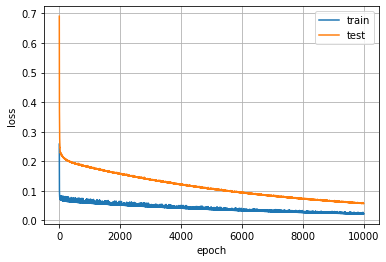

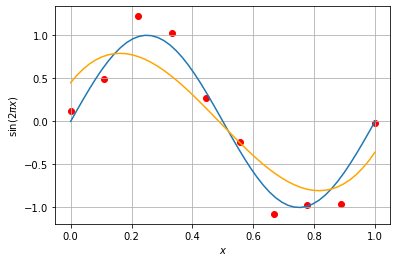

In [29]:
plt.figure()
plt.plot(np.arange(EPOCHS), train_loss)
plt.plot(np.arange(EPOCHS), test_loss)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'])
plt.grid()

model.eval()
y_pred = model(x_test_tensor)
y_pred = y_pred.detach().numpy().squeeze()

plt.figure()
plt.plot(x_test, y_test)
plt.plot(x_test, y_pred, color='orange')
plt.scatter(x_train, y_train, color='red')
plt.ylabel('$\sin(2 \pi x)$')
plt.xlabel('$x$')
plt.grid()

# Trabajo Práctico 2

Actividades:

1. Familiarizarse con los modelos, híper-parámetros y bloques constructivos (no es necesario elaborar informe sobre ellos para la entrega del TP).
1. Evaluar el uso de regularización. Evaluar el uso de función de costo L1. Hacer una búsqueda en grilla de los híper-parámetros (``learning_rate``, ``weight_decay``, ``epochs``)
1. Implementar y entrenar un modelo de red feedforward de dos capas como la segunda de la figura. Experimentar con distintos números de nodos en la capa oculta. Repetir la búsqueda de tasa de aprendizaje (learning rate) del punto anterior.
1. Con esta red neuronal, experimentar distintas funciones de activación, como la tangente hiperbólica (Tanh) o ReLU (buscar las mismas, por ejemplo, en la documentación de Pytorch).
1. Evaluar cómo cambia la convergencia de esta red neuronal con distintos valores de batch size y learning rate.
1. A partir de la versión con mini-batches, modificar el bucle de entrenamiento para que, sin modificar la iteración sobre el DataLoader, implemente descenso de gradiente estándar (actualización utilizando el gradiente sobre la función de costo acumulada, tras recorrer todo el dataset).
1. (Opcional) Buscar alguna forma de mejorar la tasa de aciertos para todas las clases del CIFAR-10 (ver notebook siguiente).
1. (Opcional) Usar una red preentrenada y hacer transfer learning (ver notebook siguiente).

Fecha de entrega: **18/06/20 23:55**